# Sentiment analysis with Finnish AFINN models
#### - Polarity labels (from -5 to 5) as negative, neutral and positive
#### - For original HS dataset of 'raw' and 'corrected' samples
#### - Preprocessing and AFINN based classification

### This script was published as a part of research work
This script was created and published by Merja Kreivi-Kauppinen.

This script is part of research work carried at University of Oulu in 2020-2023.

Topic of research work and thesis:
'Signs of Paradigm Shift in Hate Speech Detection Methodology: Hate Speech Detection of Dialectal, Granular and Urban Finnish'

### Method of sentiment analysis with afinn

Social media text polarity (multilabel) sentiment classification with afinn SA was carried on lemmatized samples, where words, emoticons and emojis were used to get sentiment scoring for text samples. 

Emoticons and emojis were taken into account in sentiment scoring.

Scoring was carried for 'raw' text samples and manually 'corrected' text samples.

Scoring with afinn was carried in three steps: (1) only for emoticons, (2) only for words, and (3) only for emojis.

 - (1) Text samples were tokenized with NLTK 'WhitespaceTokenizer' before emoticon scoring.

 - (2) Text samples were lemmatized with experimental Finnish Voikko method designed for Spacy (Spacy version 3.5.0) using large Finnish language model 'fi_core_news_lg' the source of tokens. Text samples were further tokenized with NLTK casual tokenization method, and set to lower capitals before feeding to afinn scoring process.

 - (3) Emojis of text samples were changed to english word forms before emoji scoring.

All three sentiment scores of text sample were fetched together, and after removal of zero values, the final scoring result of a sample was achieved by calculating the mean of scores.

The NaN results were set to zero, and the sample values above zero was rounded up (indicating positive label) and the sample values above zero was rounded down (indicating negative label).

Results were analyzed with methods of scikit-learn library by calculating confusion matrix, and accuracy, F1, precision and recall scores for multilabel classifier.

### Original afinn available in GitHub
Original version of Afinn method available at GitHub: https://github.com/fnielsen/afinn

Reference: Finn Årup Nielsen, "A new ANEW: evaluation of a word list for sentiment analysis in microblogs", Proceedings of the ESWC2011 Workshop on 'Making Sense of Microposts': Big things come in small packages. Volume 718 in CEUR Workshop Proceedings: 93-98. 2011 May. Matthew Rowe, Milan Stankovic, Aba-Sah Dadzie, Mariann Hardey (editors)

### Finnish AFINN lexicon for multilabel polarity sentiment classification of Finnish (social media) text samples

Documentation of FINNfin library available as README.

Finnish AFINN for polarity classification of Finnish social media text uses lexicon which includes basic, pended, subword and lemma forms of words and their polarity labels (from -5 to 5).

All lexicons (words, emoticons, emojis) were provided on lexicographically descending order to enable more precise text, emoticon, symbol and emoji matching.

 - On emotion lexicon 'fin_afinn_polarity_MerjasList_2023.txt' each word is labeled with one sentiment label (between -5 and 5)
 
 - On emoticon lexicon 'afinn_emoticon_polarity_MerjasList_2023.txt' each emoticon is labeled with one sentiment label (between -5 and 5)
 
 - On emoji lexicon 'afinn_emoji_polarity_MerjasList_2023.txt' each emoji is labeled with one sentiment label (between -5 and 5)


### The original AFINN method was sligthly modified before application to binary classification

New script available at file AFINN_scores.py

Changes in original script.
The Original AFinn class was replaced with

    - AFinnEmoticons class,
    
    - AFinnWords class, and
    
    - AfinnEmojis class

The AFinnWords class was used with 'word_boundary=True' flag to enable more precise text matching.

The AFinnWords class includes small changes in script.

New flags were added to AFinnEmoticons and AFinnEmojos classes.
The AFinnEmoticons and AFinnEmojis classes can be used with 
'emoticons_only=True' or 'emoticons_only=True' flag 
to enable text sample matching with emoticons or emojis only.

     - AFinnEmoticons class has 'emoticons_only' flag
     
     - AFinnEmojis class has 'emojis only' flag


## Import and check  jupyter python installations, packages. and libraries

In [1]:
# import python packages and libraries

import sys, re, os
import numpy as np
import pandas as pd

import string, math 
import time, datetime, random

print(f"\nPython Version: {sys.version} \n")
print(sys.executable)
print(sys.version)
print(sys.version_info)
print('\njupyter version: \n')
!jupyter --version

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split



Python Version: 3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)] 

C:\Users\merja\anaconda3\envs\NLPtfgpu\python.exe
3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)

jupyter version: 

Selected Jupyter core packages...
IPython          : 8.5.0
ipykernel        : 6.16.0
ipywidgets       : 8.0.2
jupyter_client   : 7.4.2
jupyter_core     : 4.11.1
jupyter_server   : not installed
jupyterlab       : not installed
nbclient         : 0.7.0
nbconvert        : 7.2.1
nbformat         : 5.7.0
notebook         : 6.4.12
qtconsole        : not installed
traitlets        : 5.4.0
The scikit-learn version is 1.1.2.


In [2]:
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from pylab import rcParams

# set seaborn figures
%matplotlib inline
rcParams['figure.figsize'] = 8, 4
sns.set(style='darkgrid', palette='muted', font_scale=1.0)

## Import NLP packages and AFINN for Finnish

In [3]:
import nltk
from nltk.tokenize import casual_tokenize, word_tokenize, sent_tokenize, WhitespaceTokenizer

# import AFINN folder
import AFINNfin
# import Afinn form AFINNfin for Finnish 
from AFINNfin.AFINN_scores import AfinnEmojis, AfinnEmoticons, AfinnWords

import emoji
from emoji import *
import functools
import operator

## Import Experimental Spacy and Voikko

In [4]:
# Import and check Spacy
import spacy
print(f"Spacy Version: {spacy.__version__}")

# Load large Finnish model for spacy
FinSpacyLarge = spacy.load("fi_core_news_lg")

Spacy Version: 3.5.0


In [5]:
# Test large Finnish model

# Load large Finnish model
FinSpacyLarge = spacy.load("fi_core_news_lg")

# Test the model
doc = FinSpacyLarge('Terveyden ja hyvinvoinnin laitos (THL) johtaa hanketta. Ilmassa on kevättä. Rännit tippuvat ja katuojat juoksevat.')
for t in doc:
    print(f'{t.lemma_}\t{t.pos_}')

terveys	NOUN
ja	CCONJ
hyvinvointi	NOUN
laitos	NOUN
(	PUNCT
THL	NOUN
)	PUNCT
johtaa	VERB
hanke	NOUN
.	PUNCT
Ilmassa	NOUN
olla	AUX
kevät	NOUN
.	PUNCT
Rännit	NOUN
tippua	VERB
ja	CCONJ
katuoja	NOUN
juoksevat	VERB
.	PUNCT


In [6]:
from libvoikko import Voikko
print("\nCurrent working directory " , os.getcwd())


Current working directory  C:\Users\merja\Desktop\HS_research_project\AFINN_sentiment_analysis


In [7]:
# set up Voikko search path for Voikko help
Voikko.setLibrarySearchPath("c:/Voikko")
help(Voikko)

Help on class Voikko in module libvoikko:

class Voikko(builtins.object)
 |  Voikko(language, path=None)
 |  
 |  Represents an instance of Voikko. The instance has state, such as
 |  settings related to spell checking and hyphenation, and methods for performing
 |  various natural language analysis operations. One instance should not be
 |  used simultaneously from multiple threads.
 |  
 |  Methods defined here:
 |  
 |  __del__(self)
 |  
 |  __init__(self, language, path=None)
 |      Creates a new Voikko instance with the following optional parameters:
 |      language  BCP 47 language tag to be used.
 |      path      Extra path that will be checked first when looking for linguistic
 |                resources.
 |  
 |  analyze(self, word)
 |      Analyze the morphology of given word and return the list of
 |      analysis results. The results are represented as maps having property
 |      names as keys and property values as values.
 |  
 |  attributeValues(self, attributeName)

In [8]:
# get Voikko directory list
print("\nVoikko directory list:  ", Voikko.listDicts("C:/Voikko"))


Voikko directory list:   [<fi,,standard,suomi (perussanasto)>, <fi,,dialects,suomi (murteellisten, vanhojen ja harvinaisten sanojen sanasto)>, <fi,,education,suomi (kasvatustieteen sanasto)>, <fi,,medicine,suomi (matematiikan, fysiikan, kemian, biologian, maantieteen, geologian ja lääketieteen sanastot)>, <fi,,morpho,suomi, erittäin laaja sanasto (mukana myös morfologisessa analyysissä tarvittava lisäinformaatio)>, <fi,,morphoid,suomi, erittäin laaja sanasto (mukana myös morfologisessa analyysissä tarvittava lisäinformaatio ja linkitys Joukahaiseen)>, <fi,,po,suomi (po-tiedostojen oikolukusanasto)>, <fi,,science,suomi (matematiikan, fysiikan, kemian, biologian, maantieteen, geologian, lääketieteen, kasvatustieteen ja tietotekniikan sanastot)>]


In [9]:
# get Voikko version
print("Voikko version:  ", Voikko.getVersion())

Voikko version:   4.3


In [10]:
# Test experimental Finnish Spacy model with Spacy

# Load large Finnish model
FinSpacyExp = spacy.load("spacy_fi_experimental_web_md")

# Test the model
doc = FinSpacyExp('Terveyden ja hyvinvoinnin laitos (THL) johtaa hanketta. Ilmassa on kevättä. Rännit tippuvat ja katuojat juoksevat.')
for t in doc:
    print(f'{t.lemma_}\t{t.pos_}')

terveys	NOUN
ja	CCONJ
hyvinvointi	NOUN
laitos	NOUN
(	PUNCT
THL	PROPN
)	PUNCT
johtaa	VERB
hanke	NOUN
.	PUNCT
ilma	NOUN
olla	AUX
kevät	NOUN
.	PUNCT
ränni	NOUN
tippua	VERB
ja	CCONJ
katuoja	NOUN
juosta	VERB
.	PUNCT


# Testing AFINN scoring for text data in dataframe

In [11]:
# Download labeled HS data from xlsx file to pd dataFolder

cwd = os.getcwd()
folder = '\\afinnfin\\data\\'
csv_file = 'Manually_Annotated_Collection_ALL_FINAL_22023Merja.xlsx'
csv_source = cwd + folder + csv_file
#print(csv_source)
df = pd.read_excel(csv_source)
#df

In [12]:
# Change text samples to string
df["stringSample"] = df[str("sample")]
df["stringCorrect"] = df[str("correct_finnish")]

# add string len column
df["stringLength"] = ""

# extract string length measures of data
def extract_stringLen(df):
    for item in df["stringCorrect"]:
        #newframe["stringLength"] = len(str(item))
        df["stringLength"] = df.stringCorrect.str.len()
    return df

extract_stringLen(df)
df.head(50)

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,urban_finnish,correct_finnish,user_nick,stringSample,stringCorrect,stringLength
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,negative,-1,False,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",- Ajatus siitä että kaikki henkilön tienaamat...,- Ajatus siitä että kaikki henkilön tienaamat...,Meria,- Ajatus siitä että kaikki henkilön tienaamat...,- Ajatus siitä että kaikki henkilön tienaamat...,866
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",negative,-2,False,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL","- Kaivovertauksessa, viime hallitus on kaivan...","- Kaivovertauksessa, viime hallitus on kaivan...",Meria,"- Kaivovertauksessa, viime hallitus on kaivan...","- Kaivovertauksessa, viime hallitus on kaivan...",984
2,3,--´973´¤-.ttu,negative,-5,True,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,--´973´¤-.ttu,973 vittu,Meria,--´973´¤-.ttu,973 vittu,9
3,4,-=>Widdu joo<=-,negative,-4,True,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,-=> Widdu joo <=-,-=> vittu joo <=-,Meria,-=>Widdu joo<=-,-=> vittu joo <=-,17
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",negative,-5,False,0,NaN,NaN,NaN,"SADNESS, FEAR","- Ei , mutta olen joutunut elämään katsomalla ...","Ei , mutta olen joutunut elämään katsomalla ku...",Meria,"- Ei , mutta olen joutunut elämään katsomalla ...","Ei , mutta olen joutunut elämään katsomalla ku...",144
5,6,- ei viddu -,negative,-5,True,2,NONE,"OPINION, TROLLING","SWEARING, GRANULATED",SURPRISE,ei viddu,ei vittu,Meria,- ei viddu -,ei vittu,8
6,7,- Huvittunut -,positive,1,False,0,NaN,NaN,NaN,JOY,Huvittunut,huvittunut,Meria,- Huvittunut -,huvittunut,10
7,8,"- Hyvä että JOKU näkee uuden , tyhmän veroperu...",negative,-4,True,1,NONE,OPINION,SWEARING,"MIXED EMOTIONS, JOY, ANTICIPATION CRITICAL","- Hyvä että JOKU näkee uuden , tyhmän veroperu...","Hyvä että JOKU näkee uuden, tyhmän veroperuste...",Meria,"- Hyvä että JOKU näkee uuden , tyhmän veroperu...","Hyvä että JOKU näkee uuden, tyhmän veroperuste...",124
8,9,- Kukaan luterilainen ei korota itseään hänen ...,negative,-2,False,0,NaN,NaN,NaN,SADNESS,- Kukaan luterilainen ei korota itseään hänen ...,Kukaan luterilainen ei korota itseään hänen su...,Meria,- Kukaan luterilainen ei korota itseään hänen ...,Kukaan luterilainen ei korota itseään hänen su...,105
9,10,- kuten on sovittu -,neutral,0,False,0,NaN,NaN,NaN,NEUTRAL NONE,- kuten on sovittu -,kuten on sovittu,Meria,- kuten on sovittu -,kuten on sovittu,16


In [13]:
# change sentiment values
df['sentiment'] = df['sentiment'].replace('neutral', 0)
df['sentiment'] = df['sentiment'].replace('positive', 1)
df['sentiment'] = df['sentiment'].replace('negative', -1)

# change HS / not HS values
df['HSbinary'] = df['HSbinary'].replace(False, 0)
df['HSbinary'] = df['HSbinary'].replace(True, 1)
df.tail(40)

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,urban_finnish,correct_finnish,user_nick,stringSample,stringCorrect,stringLength
6589,6590,äärimmäisen vittuuntunut.,-1,-5,1,1,NONE,OPINION,SWEARING,ANGER HATE,äärimmäisen vittuuntunut.,äärimmäisen vittuuntunut,Meria,äärimmäisen vittuuntunut.,äärimmäisen vittuuntunut,24
6590,6591,äärivassarit vittuun,-1,-5,1,2,COMMUNITY,POLITICS,"DISCRIMINATION, SWEARING",ANGER HATE,äärivassarit vittuun,äärivassarit vittuun,Meria,äärivassarit vittuun,äärivassarit vittuun,20
6591,6592,Ääs-viduilija,-1,-5,1,2,PERSON,OTHER,"INSULT, SWEARING, BULLY, GRANULATED",SARCASTIC,Ääs vittuilija,perse vittuilija,Meria,Ääs-viduilija,perse vittuilija,16
6592,6593,äää vittu mikä räkis,-1,-5,1,2,NONE,OPINION,"SWEARING, GRANULATED","SADNESS, ANGER HATE",äää vittu mikä räkis,äh vittu mikä rääkki,Meria,äää vittu mikä räkis,äh vittu mikä rääkki,20
6593,6594,Äääärimamuttajat,-1,-2,1,1,COMMUNITY,IMMIGRATION,"INSULT, DISCRIMINATION, IDIOM, BULLY, GRAN...",SARCASTIC,Ääääri mamuttajat,äärimamuttajat,Meria,Äääärimamuttajat,äärimamuttajat,14
6594,6595,äääää...vittu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED","SADNESS, ANGER HATE",äääää ... vittu,äh… vittu,Meria,äääää...vittu,äh… vittu,9
6595,6596,äääääähläm,-1,-3,1,2,COMMUNITY,"FOREIGN, TROLLING","INSULT, GRANULATED",DISGUST,äääää ähläm,ähläm,Meria,äääääähläm,ähläm,5
6596,6597,öbkibvbvittu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,öbkibvb vittu,öbkibvb vittu,Meria,öbkibvbvittu,öbkibvb vittu,13
6597,6598,öitääääääää!😴😴,0,1,0,0,NaN,NaN,NaN,NEUTRAL NONE,öitääääääää! 😴 😴,öitä! 😴 😴,Meria,öitääääääää!😴😴,öitä! 😴 😴,9
6598,6599,ÖkyrikkaatKURIINvittu,-1,-5,1,2,GROUP,STATUS,"SWEARING, GRANULATED",SARCASTIC,Ökyrikkaat KURIIN vittu,ökyrikkaat kuriin vittu,Meria,ÖkyrikkaatKURIINvittu,ökyrikkaat kuriin vittu,23


## AFINN scores for emoticons

In [14]:
# Tokenization of raw samples - with Whitespace tokenization
df['sample_WTokens'] = df["stringSample"].apply(lambda row: WhitespaceTokenizer().tokenize(str(row)))

# Tokenization of corrected samples
df['correct_WTokens'] = df["stringCorrect"].apply(lambda row: WhitespaceTokenizer().tokenize(str(row)))


In [15]:
# import AFINN folder
import AFINNfin
# import Afinn form AFINNfin for Finnish 
from AFINNfin.AFINN_scores import AfinnEmojis, AfinnEmoticons, AfinnWords

# afinn for Finnish with emoticons
AFINN_fin_EMOTICONS = AFINNfin.AFINN_scores.AfinnEmoticons(language='fin', emoticons=True, emoticons_only=True)

# ---------------------------------------------------------------------------------
# Get emoticon scores

def add_score_items_to_list(row_samples):
    collected_list = []
    for sample in row_samples:
        scores = AFINN_fin_EMOTICONS.scores(sample)
        for score in scores:    
            collected_list.append(score)        
    return collected_list
    
df['sample_AFemoc_val'] = df.apply(lambda x: add_score_items_to_list(x['sample_WTokens']), axis=1)
df['correct_AFemoc_val'] = df.apply(lambda x: add_score_items_to_list(x['correct_WTokens']), axis=1)
df.head(103)

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,urban_finnish,correct_finnish,user_nick,stringSample,stringCorrect,stringLength,sample_WTokens,correct_WTokens,sample_AFemoc_val,correct_AFemoc_val
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,-1,-1,0,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",- Ajatus siitä että kaikki henkilön tienaamat...,- Ajatus siitä että kaikki henkilön tienaamat...,Meria,- Ajatus siitä että kaikki henkilön tienaamat...,- Ajatus siitä että kaikki henkilön tienaamat...,866,"[-, Ajatus, siitä, että, kaikki, henkilön, tie...","[-, Ajatus, siitä, että, kaikki, henkilön, tie...",[],[]
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,-2,0,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL","- Kaivovertauksessa, viime hallitus on kaivan...","- Kaivovertauksessa, viime hallitus on kaivan...",Meria,"- Kaivovertauksessa, viime hallitus on kaivan...","- Kaivovertauksessa, viime hallitus on kaivan...",984,"[-, Kaivovertauksessa,, viime, hallitus, on, k...","[-, Kaivovertauksessa,, viime, hallitus, on, k...",[],[]
2,3,--´973´¤-.ttu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,--´973´¤-.ttu,973 vittu,Meria,--´973´¤-.ttu,973 vittu,9,[--´973´¤-.ttu],"[973, vittu]",[],[]
3,4,-=>Widdu joo<=-,-1,-4,1,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,-=> Widdu joo <=-,-=> vittu joo <=-,Meria,-=>Widdu joo<=-,-=> vittu joo <=-,17,"[-=>Widdu, joo<=-]","[-=>, vittu, joo, <=-]",[1],[1]
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,-5,0,0,NaN,NaN,NaN,"SADNESS, FEAR","- Ei , mutta olen joutunut elämään katsomalla ...","Ei , mutta olen joutunut elämään katsomalla ku...",Meria,"- Ei , mutta olen joutunut elämään katsomalla ...","Ei , mutta olen joutunut elämään katsomalla ku...",144,"[-, Ei, ,, mutta, olen, joutunut, elämään, kat...","[Ei, ,, mutta, olen, joutunut, elämään, katsom...",[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,99,"""nais-oletettuja"" xD",1,2,0,0,NaN,NaN,NaN,"JOY, SARCASTIC","""nais-oletettuja"" xD","""nais-oletettuja"" xD",Meria,"""nais-oletettuja"" xD","""nais-oletettuja"" xD",20,"[""nais-oletettuja"", xD]","[""nais-oletettuja"", xD]",[3],[3]
99,100,"""Näin me vihreät ajattelemme"". Hauska pätkä.",1,2,0,0,NaN,NaN,NaN,"NEUTRAL NONE, SARCASTIC","""Näin me vihreät ajattelemme"". Hauska pätkä.","""Näin me vihreät ajattelemme"". Hauska pätkä.",Meria,"""Näin me vihreät ajattelemme"". Hauska pätkä.","""Näin me vihreät ajattelemme"". Hauska pätkä.",44,"[""Näin, me, vihreät, ajattelemme""., Hauska, pä...","[""Näin, me, vihreät, ajattelemme""., Hauska, pä...",[],[]
100,101,"""Olen terve kuin pukki...""\n""...Pipsa 5 vuoden...",0,0,0,0,NaN,NaN,NaN,"MIXED EMOTIONS, ANTICIPATION CRITICAL","""Olen terve kuin pukki...""""...Pipsa 5 vuoden p...","""Olen terve kuin pukki..."" ""... Pipsa 5 vuoden...",Meria,"""Olen terve kuin pukki...""\n""...Pipsa 5 vuoden...","""Olen terve kuin pukki..."" ""... Pipsa 5 vuoden...",82,"[""Olen, terve, kuin, pukki..."", ""...Pipsa, 5, ...","[""Olen, terve, kuin, pukki..."", ""..., Pipsa, 5...",[],[]
101,102,"""Ootsä mies?""",0,0,0,0,NaN,NaN,NaN,NEUTRAL NONE,"""Ootsä mies?""","""Oletko sinä mies?""",Meria,"""Ootsä mies?""","""Oletko sinä mies?""",19,"[""Ootsä, mies?""]","[""Oletko, sinä, mies?""]",[],[]


## Lemmatization with experimental Fin Spacy and AFINN scores for words

In [16]:
# Lemmatization of raw samples
df['sampleLemmas'] = df['stringSample'].apply(lambda row: " ".join([token.lemma_ for token in FinSpacyExp(row)]))

# Lemmatization of corrected samples
df['correctLemmas'] = df['stringCorrect'].apply(lambda row: " ".join([token.lemma_ for token in FinSpacyExp(row)]))
df.head(10)

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,user_nick,stringSample,stringCorrect,stringLength,sample_WTokens,correct_WTokens,sample_AFemoc_val,correct_AFemoc_val,sampleLemmas,correctLemmas
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,-1,-1,0,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",...,Meria,- Ajatus siitä että kaikki henkilön tienaamat...,- Ajatus siitä että kaikki henkilön tienaamat...,866,"[-, Ajatus, siitä, että, kaikki, henkilön, tie...","[-, Ajatus, siitä, että, kaikki, henkilön, tie...",[],[],- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,-2,0,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL",...,Meria,"- Kaivovertauksessa, viime hallitus on kaivan...","- Kaivovertauksessa, viime hallitus on kaivan...",984,"[-, Kaivovertauksessa,, viime, hallitus, on, k...","[-, Kaivovertauksessa,, viime, hallitus, on, k...",[],[],"- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ..."
2,3,--´973´¤-.ttu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,Meria,--´973´¤-.ttu,973 vittu,9,[--´973´¤-.ttu],"[973, vittu]",[],[],--´973´¤-.ttu,973 vittu
3,4,-=>Widdu joo<=-,-1,-4,1,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,...,Meria,-=>Widdu joo<=-,-=> vittu joo <=-,17,"[-=>Widdu, joo<=-]","[-=>, vittu, joo, <=-]",[1],[1],-=>Widdu joo<= -,-= > vittu joo < = -
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,-5,0,0,NaN,NaN,NaN,"SADNESS, FEAR",...,Meria,"- Ei , mutta olen joutunut elämään katsomalla ...","Ei , mutta olen joutunut elämään katsomalla ku...",144,"[-, Ei, ,, mutta, olen, joutunut, elämään, kat...","[Ei, ,, mutta, olen, joutunut, elämään, katsom...",[],[],"- ei , mutta olla joutua elää katsoa kuinka ki...","ei , mutta olla joutua elää katsoa kuinka kius..."
5,6,- ei viddu -,-1,-5,1,2,NONE,"OPINION, TROLLING","SWEARING, GRANULATED",SURPRISE,...,Meria,- ei viddu -,ei vittu,8,"[-, ei, viddu, -]","[ei, vittu]",[],[],- ei viddu -,ei vittu
6,7,- Huvittunut -,1,1,0,0,NaN,NaN,NaN,JOY,...,Meria,- Huvittunut -,huvittunut,10,"[-, Huvittunut, -]",[huvittunut],[],[],- huvittunut -,huvittua
7,8,"- Hyvä että JOKU näkee uuden , tyhmän veroperu...",-1,-4,1,1,NONE,OPINION,SWEARING,"MIXED EMOTIONS, JOY, ANTICIPATION CRITICAL",...,Meria,"- Hyvä että JOKU näkee uuden , tyhmän veroperu...","Hyvä että JOKU näkee uuden, tyhmän veroperuste...",124,"[-, Hyvä, että, JOKU, näkee, uuden, ,, tyhmän,...","[Hyvä, että, JOKU, näkee, uuden,, tyhmän, vero...",[],[],"- hyvä että joku nähdä uusi , tyhmä veroperust...","hyvä että joku nähdä uusi , tyhmä veroperuste ..."
8,9,- Kukaan luterilainen ei korota itseään hänen ...,-1,-2,0,0,NaN,NaN,NaN,SADNESS,...,Meria,- Kukaan luterilainen ei korota itseään hänen ...,Kukaan luterilainen ei korota itseään hänen su...,105,"[-, Kukaan, luterilainen, ei, korota, itseään,...","[Kukaan, luterilainen, ei, korota, itseään, hä...",[],[],- kukaan luterilainen ei korottaa itse hän suh...,kukaan luterilainen ei korottaa itse hän suhde...
9,10,- kuten on sovittu -,0,0,0,0,NaN,NaN,NaN,NEUTRAL NONE,...,Meria,- kuten on sovittu -,kuten on sovittu,16,"[-, kuten, on, sovittu, -]","[kuten, on, sovittu]",[],[],- kuten olla sopia -,kuten olla sopia


In [17]:
# Tokenization of raw samples with casual tokenization
df['sampleTokens'] = df['sampleLemmas'].apply(lambda row:casual_tokenize(row))

# Tokenization of corrected samples
df['correctTokens'] = df['correctLemmas'].apply(lambda row: casual_tokenize(row))
df.head(10)

# WhitespaceTokenizer().tokenize(str(text_sample))

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,stringCorrect,stringLength,sample_WTokens,correct_WTokens,sample_AFemoc_val,correct_AFemoc_val,sampleLemmas,correctLemmas,sampleTokens,correctTokens
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,-1,-1,0,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",...,- Ajatus siitä että kaikki henkilön tienaamat...,866,"[-, Ajatus, siitä, että, kaikki, henkilön, tie...","[-, Ajatus, siitä, että, kaikki, henkilön, tie...",[],[],- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...,"[-, ajatus, se, että, kaikki, henkilö, tienata...","[-, ajatus, se, että, kaikki, henkilö, tienata..."
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,-2,0,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL",...,"- Kaivovertauksessa, viime hallitus on kaivan...",984,"[-, Kaivovertauksessa,, viime, hallitus, on, k...","[-, Kaivovertauksessa,, viime, hallitus, on, k...",[],[],"- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ...","[-, kaivovertaus, ,, viime, hallitus, olla, ka...","[-, kaivovertaus, ,, viime, hallitus, olla, ka..."
2,3,--´973´¤-.ttu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,973 vittu,9,[--´973´¤-.ttu],"[973, vittu]",[],[],--´973´¤-.ttu,973 vittu,"[-, -, ´, 973, ´, ¤, -, ., ttu]","[973, vittu]"
3,4,-=>Widdu joo<=-,-1,-4,1,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,...,-=> vittu joo <=-,17,"[-=>Widdu, joo<=-]","[-=>, vittu, joo, <=-]",[1],[1],-=>Widdu joo<= -,-= > vittu joo < = -,"[-, =, >, Widdu, joo, <, =, -]","[-, =, >, vittu, joo, <, =, -]"
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,-5,0,0,NaN,NaN,NaN,"SADNESS, FEAR",...,"Ei , mutta olen joutunut elämään katsomalla ku...",144,"[-, Ei, ,, mutta, olen, joutunut, elämään, kat...","[Ei, ,, mutta, olen, joutunut, elämään, katsom...",[],[],"- ei , mutta olla joutua elää katsoa kuinka ki...","ei , mutta olla joutua elää katsoa kuinka kius...","[-, ei, ,, mutta, olla, joutua, elää, katsoa, ...","[ei, ,, mutta, olla, joutua, elää, katsoa, kui..."
5,6,- ei viddu -,-1,-5,1,2,NONE,"OPINION, TROLLING","SWEARING, GRANULATED",SURPRISE,...,ei vittu,8,"[-, ei, viddu, -]","[ei, vittu]",[],[],- ei viddu -,ei vittu,"[-, ei, viddu, -]","[ei, vittu]"
6,7,- Huvittunut -,1,1,0,0,NaN,NaN,NaN,JOY,...,huvittunut,10,"[-, Huvittunut, -]",[huvittunut],[],[],- huvittunut -,huvittua,"[-, huvittunut, -]",[huvittua]
7,8,"- Hyvä että JOKU näkee uuden , tyhmän veroperu...",-1,-4,1,1,NONE,OPINION,SWEARING,"MIXED EMOTIONS, JOY, ANTICIPATION CRITICAL",...,"Hyvä että JOKU näkee uuden, tyhmän veroperuste...",124,"[-, Hyvä, että, JOKU, näkee, uuden, ,, tyhmän,...","[Hyvä, että, JOKU, näkee, uuden,, tyhmän, vero...",[],[],"- hyvä että joku nähdä uusi , tyhmä veroperust...","hyvä että joku nähdä uusi , tyhmä veroperuste ...","[-, hyvä, että, joku, nähdä, uusi, ,, tyhmä, v...","[hyvä, että, joku, nähdä, uusi, ,, tyhmä, vero..."
8,9,- Kukaan luterilainen ei korota itseään hänen ...,-1,-2,0,0,NaN,NaN,NaN,SADNESS,...,Kukaan luterilainen ei korota itseään hänen su...,105,"[-, Kukaan, luterilainen, ei, korota, itseään,...","[Kukaan, luterilainen, ei, korota, itseään, hä...",[],[],- kukaan luterilainen ei korottaa itse hän suh...,kukaan luterilainen ei korottaa itse hän suhde...,"[-, kukaan, luterilainen, ei, korottaa, itse, ...","[kukaan, luterilainen, ei, korottaa, itse, hän..."
9,10,- kuten on sovittu -,0,0,0,0,NaN,NaN,NaN,NEUTRAL NONE,...,kuten on sovittu,16,"[-, kuten, on, sovittu, -]","[kuten, on, sovittu]",[],[],- kuten olla sopia -,kuten olla sopia,"[-, kuten, olla, sopia, -]","[kuten, olla, sopia]"


In [18]:
# lower samples
df['sampleTokens'] = df['sampleTokens'].apply(lambda row: [token.lower() for token in row])

# lower samples
df['correctTokens'] = df['correctTokens'].apply(lambda row: [token.lower() for token in row])
df.head(10)

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,stringCorrect,stringLength,sample_WTokens,correct_WTokens,sample_AFemoc_val,correct_AFemoc_val,sampleLemmas,correctLemmas,sampleTokens,correctTokens
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,-1,-1,0,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",...,- Ajatus siitä että kaikki henkilön tienaamat...,866,"[-, Ajatus, siitä, että, kaikki, henkilön, tie...","[-, Ajatus, siitä, että, kaikki, henkilön, tie...",[],[],- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...,"[-, ajatus, se, että, kaikki, henkilö, tienata...","[-, ajatus, se, että, kaikki, henkilö, tienata..."
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,-2,0,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL",...,"- Kaivovertauksessa, viime hallitus on kaivan...",984,"[-, Kaivovertauksessa,, viime, hallitus, on, k...","[-, Kaivovertauksessa,, viime, hallitus, on, k...",[],[],"- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ...","[-, kaivovertaus, ,, viime, hallitus, olla, ka...","[-, kaivovertaus, ,, viime, hallitus, olla, ka..."
2,3,--´973´¤-.ttu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,973 vittu,9,[--´973´¤-.ttu],"[973, vittu]",[],[],--´973´¤-.ttu,973 vittu,"[-, -, ´, 973, ´, ¤, -, ., ttu]","[973, vittu]"
3,4,-=>Widdu joo<=-,-1,-4,1,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,...,-=> vittu joo <=-,17,"[-=>Widdu, joo<=-]","[-=>, vittu, joo, <=-]",[1],[1],-=>Widdu joo<= -,-= > vittu joo < = -,"[-, =, >, widdu, joo, <, =, -]","[-, =, >, vittu, joo, <, =, -]"
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,-5,0,0,NaN,NaN,NaN,"SADNESS, FEAR",...,"Ei , mutta olen joutunut elämään katsomalla ku...",144,"[-, Ei, ,, mutta, olen, joutunut, elämään, kat...","[Ei, ,, mutta, olen, joutunut, elämään, katsom...",[],[],"- ei , mutta olla joutua elää katsoa kuinka ki...","ei , mutta olla joutua elää katsoa kuinka kius...","[-, ei, ,, mutta, olla, joutua, elää, katsoa, ...","[ei, ,, mutta, olla, joutua, elää, katsoa, kui..."
5,6,- ei viddu -,-1,-5,1,2,NONE,"OPINION, TROLLING","SWEARING, GRANULATED",SURPRISE,...,ei vittu,8,"[-, ei, viddu, -]","[ei, vittu]",[],[],- ei viddu -,ei vittu,"[-, ei, viddu, -]","[ei, vittu]"
6,7,- Huvittunut -,1,1,0,0,NaN,NaN,NaN,JOY,...,huvittunut,10,"[-, Huvittunut, -]",[huvittunut],[],[],- huvittunut -,huvittua,"[-, huvittunut, -]",[huvittua]
7,8,"- Hyvä että JOKU näkee uuden , tyhmän veroperu...",-1,-4,1,1,NONE,OPINION,SWEARING,"MIXED EMOTIONS, JOY, ANTICIPATION CRITICAL",...,"Hyvä että JOKU näkee uuden, tyhmän veroperuste...",124,"[-, Hyvä, että, JOKU, näkee, uuden, ,, tyhmän,...","[Hyvä, että, JOKU, näkee, uuden,, tyhmän, vero...",[],[],"- hyvä että joku nähdä uusi , tyhmä veroperust...","hyvä että joku nähdä uusi , tyhmä veroperuste ...","[-, hyvä, että, joku, nähdä, uusi, ,, tyhmä, v...","[hyvä, että, joku, nähdä, uusi, ,, tyhmä, vero..."
8,9,- Kukaan luterilainen ei korota itseään hänen ...,-1,-2,0,0,NaN,NaN,NaN,SADNESS,...,Kukaan luterilainen ei korota itseään hänen su...,105,"[-, Kukaan, luterilainen, ei, korota, itseään,...","[Kukaan, luterilainen, ei, korota, itseään, hä...",[],[],- kukaan luterilainen ei korottaa itse hän suh...,kukaan luterilainen ei korottaa itse hän suhde...,"[-, kukaan, luterilainen, ei, korottaa, itse, ...","[kukaan, luterilainen, ei, korottaa, itse, hän..."
9,10,- kuten on sovittu -,0,0,0,0,NaN,NaN,NaN,NEUTRAL NONE,...,kuten on sovittu,16,"[-, kuten, on, sovittu, -]","[kuten, on, sovittu]",[],[],- kuten olla sopia -,kuten olla sopia,"[-, kuten, olla, sopia, -]","[kuten, olla, sopia]"


In [19]:
# import AFINN folder
import AFINNfin
# import Afinn form AFINNfin for Finnish 
from AFINNfin.AFINN_scores import AfinnEmojis, AfinnEmoticons, AfinnWords

# afinn for Finnish words
# initialize afinn sentiment analyzer for lemmatized Finnish
AFINN_fin = AFINNfin.AFINN_scores.AfinnWords(language='fin')

# ---------------------------------------------------------------------------------
# Get word scores

def add_score_items_to_list(row_samples):
    collected_list = []
    for sample in row_samples:
        scores = AFINN_fin.scores(sample)
        for score in scores:    
            collected_list.append(score)        
    return collected_list

df['sample_AFword_val'] = df.apply(lambda row: add_score_items_to_list(row['sampleTokens']), axis=1)
df['correct_AFword_val'] = df.apply(lambda row: add_score_items_to_list(row['correctTokens']), axis=1)
df.head(103)


,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,sample_WTokens,correct_WTokens,sample_AFemoc_val,correct_AFemoc_val,sampleLemmas,correctLemmas,sampleTokens,correctTokens,sample_AFword_val,correct_AFword_val
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,-1,-1,0,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",...,"[-, Ajatus, siitä, että, kaikki, henkilön, tie...","[-, Ajatus, siitä, että, kaikki, henkilön, tie...",[],[],- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...,"[-, ajatus, se, että, kaikki, henkilö, tienata...","[-, ajatus, se, että, kaikki, henkilö, tienata...","[1, 0, 1, -1, 0, -3, -1, -1, 1, 1, -2, -1, -2,...","[1, 0, 1, -1, 0, -3, -1, -1, 1, 1, -2, -1, -2,..."
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,-2,0,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL",...,"[-, Kaivovertauksessa,, viime, hallitus, on, k...","[-, Kaivovertauksessa,, viime, hallitus, on, k...",[],[],"- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ...","[-, kaivovertaus, ,, viime, hallitus, olla, ka...","[-, kaivovertaus, ,, viime, hallitus, olla, ka...","[1, 0, 0, -2, 1, -1, -1, 1, -4, 1, 0, 0, 0, 1,...","[1, 0, 0, -2, 1, -1, -1, 1, -4, 1, 0, 0, 0, 1,..."
2,3,--´973´¤-.ttu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,[--´973´¤-.ttu],"[973, vittu]",[],[],--´973´¤-.ttu,973 vittu,"[-, -, ´, 973, ´, ¤, -, ., ttu]","[973, vittu]",[],[-5]
3,4,-=>Widdu joo<=-,-1,-4,1,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,...,"[-=>Widdu, joo<=-]","[-=>, vittu, joo, <=-]",[1],[1],-=>Widdu joo<= -,-= > vittu joo < = -,"[-, =, >, widdu, joo, <, =, -]","[-, =, >, vittu, joo, <, =, -]",[],[-5]
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,-5,0,0,NaN,NaN,NaN,"SADNESS, FEAR",...,"[-, Ei, ,, mutta, olen, joutunut, elämään, kat...","[Ei, ,, mutta, olen, joutunut, elämään, katsom...",[],[],"- ei , mutta olla joutua elää katsoa kuinka ki...","ei , mutta olla joutua elää katsoa kuinka kius...","[-, ei, ,, mutta, olla, joutua, elää, katsoa, ...","[ei, ,, mutta, olla, joutua, elää, katsoa, kui...","[-2, 0, -1, 1, -3, 0, -1, -2, 0, 1]","[-2, 0, -1, 1, -3, 0, -1, -2, 0, 1]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,99,"""nais-oletettuja"" xD",1,2,0,0,NaN,NaN,NaN,"JOY, SARCASTIC",...,"[""nais-oletettuja"", xD]","[""nais-oletettuja"", xD]",[3],[3],""" nais-oletettu "" xD",""" nais-oletettu "" xD","["", nais-oletettu, "", xd]","["", nais-oletettu, "", xd]",[],[]
99,100,"""Näin me vihreät ajattelemme"". Hauska pätkä.",1,2,0,0,NaN,NaN,NaN,"NEUTRAL NONE, SARCASTIC",...,"[""Näin, me, vihreät, ajattelemme""., Hauska, pä...","[""Näin, me, vihreät, ajattelemme""., Hauska, pä...",[],[],""" näin minä vihreä ajatella "" . hauska pätkä .",""" näin minä vihreä ajatella "" . hauska pätkä .","["", näin, minä, vihreä, ajatella, "", ., hauska...","["", näin, minä, vihreä, ajatella, "", ., hauska...","[1, 2]","[1, 2]"
100,101,"""Olen terve kuin pukki...""\n""...Pipsa 5 vuoden...",0,0,0,0,NaN,NaN,NaN,"MIXED EMOTIONS, ANTICIPATION CRITICAL",...,"[""Olen, terve, kuin, pukki..."", ""...Pipsa, 5, ...","[""Olen, terve, kuin, pukki..."", ""..., Pipsa, 5...",[],[],""" olla terve kuin pukki ... "" \n "" ... Pipsa 5...",""" olla terve kuin pukki ... "" "" ... Pipsa 5 vu...","["", olla, terve, kuin, pukki, ..., "", "", ..., ...","["", olla, terve, kuin, pukki, ..., "", "", ..., ...","[0, 2, 1, 1, 0, 1, 2]","[0, 2, 1, 1, 0, 1, 2]"
101,102,"""Ootsä mies?""",0,0,0,0,NaN,NaN,NaN,NEUTRAL NONE,...,"[""Ootsä, mies?""]","[""Oletko, sinä, mies?""]",[],[],""" ootsä mies ? """,""" olla se mies ? ""","["", ootsä, mies, ?, ""]","["", olla, se, mies, ?, ""]",[],[0]


# AFINN scores for emojis

In [20]:
# emoji analyze
df['emoji_analyze'] = df['sample'].apply(lambda row: emoji.analyze(row))
df

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,correct_WTokens,sample_AFemoc_val,correct_AFemoc_val,sampleLemmas,correctLemmas,sampleTokens,correctTokens,sample_AFword_val,correct_AFword_val,emoji_analyze
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,-1,-1,0,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",...,"[-, Ajatus, siitä, että, kaikki, henkilön, tie...",[],[],- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...,"[-, ajatus, se, että, kaikki, henkilö, tienata...","[-, ajatus, se, että, kaikki, henkilö, tienata...","[1, 0, 1, -1, 0, -3, -1, -1, 1, 1, -2, -1, -2,...","[1, 0, 1, -1, 0, -3, -1, -1, 1, 1, -2, -1, -2,...",<generator object filter_tokens at 0x00000146A...
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,-2,0,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL",...,"[-, Kaivovertauksessa,, viime, hallitus, on, k...",[],[],"- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ...","[-, kaivovertaus, ,, viime, hallitus, olla, ka...","[-, kaivovertaus, ,, viime, hallitus, olla, ka...","[1, 0, 0, -2, 1, -1, -1, 1, -4, 1, 0, 0, 0, 1,...","[1, 0, 0, -2, 1, -1, -1, 1, -4, 1, 0, 0, 0, 1,...",<generator object filter_tokens at 0x00000146A...
2,3,--´973´¤-.ttu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,"[973, vittu]",[],[],--´973´¤-.ttu,973 vittu,"[-, -, ´, 973, ´, ¤, -, ., ttu]","[973, vittu]",[],[-5],<generator object filter_tokens at 0x00000146A...
3,4,-=>Widdu joo<=-,-1,-4,1,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,...,"[-=>, vittu, joo, <=-]",[1],[1],-=>Widdu joo<= -,-= > vittu joo < = -,"[-, =, >, widdu, joo, <, =, -]","[-, =, >, vittu, joo, <, =, -]",[],[-5],<generator object filter_tokens at 0x00000146A...
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,-5,0,0,NaN,NaN,NaN,"SADNESS, FEAR",...,"[Ei, ,, mutta, olen, joutunut, elämään, katsom...",[],[],"- ei , mutta olla joutua elää katsoa kuinka ki...","ei , mutta olla joutua elää katsoa kuinka kius...","[-, ei, ,, mutta, olla, joutua, elää, katsoa, ...","[ei, ,, mutta, olla, joutua, elää, katsoa, kui...","[-2, 0, -1, 1, -3, 0, -1, -2, 0, 1]","[-2, 0, -1, 1, -3, 0, -1, -2, 0, 1]",<generator object filter_tokens at 0x00000146A...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6624,6625,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,1,5,0,0,NaN,NaN,NaN,JOY,...,[😂😂😂😂😂],[],[],😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂,😂 😂 😂 😂 😂,"[😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂]","[😂, 😂, 😂, 😂, 😂]",[],[],<generator object filter_tokens at 0x00000146A...
6625,6626,😠👉👩‍💼,-1,-3,0,0,NaN,NaN,NaN,ANGER HATE,...,[😠👉👩‍💼],[],[],😠 👉 👩 ‍ 💼,😠 👉 👩 ‍ 💼,"[😠, 👉, 👩, ‍ , 💼]","[😠, 👉, 👩, ‍ , 💼]",[],[],<generator object filter_tokens at 0x00000146A...
6626,6627,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,1,5,0,0,NaN,NaN,NaN,JOY,...,[🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣],[],[],🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣,🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣,"[🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣]","[🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣]",[],[],<generator object filter_tokens at 0x00000146A...
6627,6628,🤮😡,-1,-4,0,0,NaN,NaN,NaN,"DISGUST, ANGER HATE",...,[🤮😡],[],[],🤮 😡,🤮 😡,"[🤮, 😡]","[🤮, 😡]",[],[],<generator object filter_tokens at 0x00000146A...


In [21]:
# emoji tokens
df['emoji_tokens'] = df['emoji_analyze'].apply(lambda row: [token.value.emoji for token in row])
df

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,sample_AFemoc_val,correct_AFemoc_val,sampleLemmas,correctLemmas,sampleTokens,correctTokens,sample_AFword_val,correct_AFword_val,emoji_analyze,emoji_tokens
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,-1,-1,0,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",...,[],[],- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...,"[-, ajatus, se, että, kaikki, henkilö, tienata...","[-, ajatus, se, että, kaikki, henkilö, tienata...","[1, 0, 1, -1, 0, -3, -1, -1, 1, 1, -2, -1, -2,...","[1, 0, 1, -1, 0, -3, -1, -1, 1, 1, -2, -1, -2,...",<generator object filter_tokens at 0x00000146A...,[]
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,-2,0,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL",...,[],[],"- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ...","[-, kaivovertaus, ,, viime, hallitus, olla, ka...","[-, kaivovertaus, ,, viime, hallitus, olla, ka...","[1, 0, 0, -2, 1, -1, -1, 1, -4, 1, 0, 0, 0, 1,...","[1, 0, 0, -2, 1, -1, -1, 1, -4, 1, 0, 0, 0, 1,...",<generator object filter_tokens at 0x00000146A...,[]
2,3,--´973´¤-.ttu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,[],[],--´973´¤-.ttu,973 vittu,"[-, -, ´, 973, ´, ¤, -, ., ttu]","[973, vittu]",[],[-5],<generator object filter_tokens at 0x00000146A...,[]
3,4,-=>Widdu joo<=-,-1,-4,1,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,...,[1],[1],-=>Widdu joo<= -,-= > vittu joo < = -,"[-, =, >, widdu, joo, <, =, -]","[-, =, >, vittu, joo, <, =, -]",[],[-5],<generator object filter_tokens at 0x00000146A...,[]
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,-5,0,0,NaN,NaN,NaN,"SADNESS, FEAR",...,[],[],"- ei , mutta olla joutua elää katsoa kuinka ki...","ei , mutta olla joutua elää katsoa kuinka kius...","[-, ei, ,, mutta, olla, joutua, elää, katsoa, ...","[ei, ,, mutta, olla, joutua, elää, katsoa, kui...","[-2, 0, -1, 1, -3, 0, -1, -2, 0, 1]","[-2, 0, -1, 1, -3, 0, -1, -2, 0, 1]",<generator object filter_tokens at 0x00000146A...,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6624,6625,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,1,5,0,0,NaN,NaN,NaN,JOY,...,[],[],😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂,😂 😂 😂 😂 😂,"[😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂]","[😂, 😂, 😂, 😂, 😂]",[],[],<generator object filter_tokens at 0x00000146A...,"[😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂]"
6625,6626,😠👉👩‍💼,-1,-3,0,0,NaN,NaN,NaN,ANGER HATE,...,[],[],😠 👉 👩 ‍ 💼,😠 👉 👩 ‍ 💼,"[😠, 👉, 👩, ‍ , 💼]","[😠, 👉, 👩, ‍ , 💼]",[],[],<generator object filter_tokens at 0x00000146A...,"[😠, 👉, 👩‍💼]"
6626,6627,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,1,5,0,0,NaN,NaN,NaN,JOY,...,[],[],🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣,🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣,"[🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣]","[🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣]",[],[],<generator object filter_tokens at 0x00000146A...,"[🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣]"
6627,6628,🤮😡,-1,-4,0,0,NaN,NaN,NaN,"DISGUST, ANGER HATE",...,[],[],🤮 😡,🤮 😡,"[🤮, 😡]","[🤮, 😡]",[],[],<generator object filter_tokens at 0x00000146A...,"[🤮, 😡]"


In [22]:
# emoji definitions
df['demojize'] = df['emoji_tokens'].apply(lambda row: [emoji.demojize(token) for token in row])
df

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,correct_AFemoc_val,sampleLemmas,correctLemmas,sampleTokens,correctTokens,sample_AFword_val,correct_AFword_val,emoji_analyze,emoji_tokens,demojize
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,-1,-1,0,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",...,[],- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...,"[-, ajatus, se, että, kaikki, henkilö, tienata...","[-, ajatus, se, että, kaikki, henkilö, tienata...","[1, 0, 1, -1, 0, -3, -1, -1, 1, 1, -2, -1, -2,...","[1, 0, 1, -1, 0, -3, -1, -1, 1, 1, -2, -1, -2,...",<generator object filter_tokens at 0x00000146A...,[],[]
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,-2,0,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL",...,[],"- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ...","[-, kaivovertaus, ,, viime, hallitus, olla, ka...","[-, kaivovertaus, ,, viime, hallitus, olla, ka...","[1, 0, 0, -2, 1, -1, -1, 1, -4, 1, 0, 0, 0, 1,...","[1, 0, 0, -2, 1, -1, -1, 1, -4, 1, 0, 0, 0, 1,...",<generator object filter_tokens at 0x00000146A...,[],[]
2,3,--´973´¤-.ttu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,[],--´973´¤-.ttu,973 vittu,"[-, -, ´, 973, ´, ¤, -, ., ttu]","[973, vittu]",[],[-5],<generator object filter_tokens at 0x00000146A...,[],[]
3,4,-=>Widdu joo<=-,-1,-4,1,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,...,[1],-=>Widdu joo<= -,-= > vittu joo < = -,"[-, =, >, widdu, joo, <, =, -]","[-, =, >, vittu, joo, <, =, -]",[],[-5],<generator object filter_tokens at 0x00000146A...,[],[]
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,-5,0,0,NaN,NaN,NaN,"SADNESS, FEAR",...,[],"- ei , mutta olla joutua elää katsoa kuinka ki...","ei , mutta olla joutua elää katsoa kuinka kius...","[-, ei, ,, mutta, olla, joutua, elää, katsoa, ...","[ei, ,, mutta, olla, joutua, elää, katsoa, kui...","[-2, 0, -1, 1, -3, 0, -1, -2, 0, 1]","[-2, 0, -1, 1, -3, 0, -1, -2, 0, 1]",<generator object filter_tokens at 0x00000146A...,[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6624,6625,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,1,5,0,0,NaN,NaN,NaN,JOY,...,[],😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂,😂 😂 😂 😂 😂,"[😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂]","[😂, 😂, 😂, 😂, 😂]",[],[],<generator object filter_tokens at 0x00000146A...,"[😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂]","[:face_with_tears_of_joy:, :face_with_tears_of..."
6625,6626,😠👉👩‍💼,-1,-3,0,0,NaN,NaN,NaN,ANGER HATE,...,[],😠 👉 👩 ‍ 💼,😠 👉 👩 ‍ 💼,"[😠, 👉, 👩, ‍ , 💼]","[😠, 👉, 👩, ‍ , 💼]",[],[],<generator object filter_tokens at 0x00000146A...,"[😠, 👉, 👩‍💼]","[:angry_face:, :backhand_index_pointing_right:..."
6626,6627,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,1,5,0,0,NaN,NaN,NaN,JOY,...,[],🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣,🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣,"[🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣]","[🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣]",[],[],<generator object filter_tokens at 0x00000146A...,"[🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣]","[:rolling_on_the_floor_laughing:, :rolling_on_..."
6627,6628,🤮😡,-1,-4,0,0,NaN,NaN,NaN,"DISGUST, ANGER HATE",...,[],🤮 😡,🤮 😡,"[🤮, 😡]","[🤮, 😡]",[],[],<generator object filter_tokens at 0x00000146A...,"[🤮, 😡]","[:face_vomiting:, :enraged_face:]"


In [23]:
# import AFINN folder
import AFINNfin
# import Afinn form AFINNfin for Finnish 
from AFINNfin.AFINN_scores import AfinnEmojis, AfinnEmoticons, AfinnWords

# afinn for Finnish with emojis
AFINN_fin_EMOJIS = AFINNfin.AFINN_scores.AfinnEmojis(language='fin', emojis=True, emojis_only=True)     

# ---------------------------------------------------------------------------------
# Get emoji scores

def add_score_items_to_list(row_samples):
    collected_list = []
    for sample in row_samples:
        scores = AFINN_fin_EMOTICONS.scores(sample)
        for score in scores:    
            collected_list.append(score)        
    return collected_list
    
df['sample_emoji_values'] = df.apply(lambda row: add_score_items_to_list(row['demojize']), axis=1)
df.tail(20)

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,sampleLemmas,correctLemmas,sampleTokens,correctTokens,sample_AFword_val,correct_AFword_val,emoji_analyze,emoji_tokens,demojize,sample_emoji_values
6609,6610,ÖÖ T:VITTU,-1,-4,1,2,NONE,TROLLING,SWEARING,"SURPRISE, CONTEMPT DISRESPECT",...,ÖÖ T:VITTU,öö T : Vittu,"[öö, t, :, vittu]","[öö, t, :, vittu]",[-5],[-5],<generator object filter_tokens at 0x00000146A...,[],[],[]
6610,6611,ÖÖ7jaKuolemanKurvit,-1,-2,0,0,NaN,NaN,NaN,"DISGUST, SARCASTIC",...,öö7jakuolemankurvit,007 ja kuolema kurvi,[öö7jakuolemankurvit],"[007, ja, kuolema, kurvi]",[],[-3],<generator object filter_tokens at 0x00000146A...,[],[],[]
6611,6612,ööliä vittu,-1,-4,1,2,NONE,"OPINION, TROLLING","SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,ööliä vittu,olut vittu,"[ööliä, vittu]","[olut, vittu]",[-5],[-5],<generator object filter_tokens at 0x00000146A...,[],[],[]
6612,6613,öö-luokkalaiset.vittuun,-1,-5,1,2,NONE,TROLLING,"JOKE SARCASM, SWEARING",SARCASTIC,...,öö-luokkalaiset.vittuun,öö-luokkalaiset vittu,"[öö-luokkalaiset, ., vittuun]","[öö-luokkalaiset, vittu]",[],[-5],<generator object filter_tokens at 0x00000146A...,[],[],[]
6613,6614,öö-vittu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",DISGUST,...,öö-vittu,öö vittu,[öö-vittu],"[öö, vittu]",[-5],[-5],<generator object filter_tokens at 0x00000146A...,[],[],[]
6614,6615,ööö,-1,-1,0,0,NaN,NaN,NaN,UNPLEASENT,...,ööö,ööö,[ööö],[ööö],[],[],<generator object filter_tokens at 0x00000146A...,[],[],[]
6615,6616,Ööö mitä vittua??,-1,-4,1,2,NONE,OPINION,"JOKE SARCASM, SWEARING",SURPRISE,...,Ööö mitä vittu ? ?,"Öö , mitä vittu ? ?","[ööö, mitä, vittu, ?, ?]","[öö, ,, mitä, vittu, ?, ?]",[-5],[-5],<generator object filter_tokens at 0x00000146A...,[],[],[]
6616,6617,Ööövittuentiiä,-1,-5,1,2,NONE,"OPINION, TROLLING","SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,ööövittuentiiä,Öö vittu ei tietää,[ööövittuentiiä],"[öö, vittu, ei, tietää]",[],"[-5, -2]",<generator object filter_tokens at 0x00000146A...,[],[],[]
6617,6618,"👍❤Hyvä Ville, sinua on ilo kuunnella, nautin a...",1,5,0,0,NaN,NaN,NaN,"JOY, HAPPINESS, TRUST",...,"👍 ❤ hyvä Ville , sinä olla ilo kuunnella , nau...","👍 ❤ hyvä Ville , sinä olla ilo kuunnella , nau...","[👍, ❤, hyvä, ville, ,, sinä, olla, ilo, kuunne...","[👍, ❤, hyvä, ville, ,, sinä, olla, ilo, kuunne...","[2, 0, 3, 2, 3, 0, 2]","[2, 0, 3, 2, 3, 0, 2]",<generator object filter_tokens at 0x00000146A...,"[👍, ❤]","[:thumbs_up:, :red_heart:]",[]
6618,6619,👍🏻,1,1,0,0,NaN,NaN,NaN,HAPPINESS,...,👍 🏻,👍 🏻,"[👍, 🏻]","[👍, 🏻]",[],[],<generator object filter_tokens at 0x00000146A...,[👍🏻],[:thumbs_up_light_skin_tone:],[]


# Check the value validity of measurements

In [24]:
def check_value_validity_string(column_value):
    for values in column_value:
        splitted = values.split(",")
        for item in splitted:    
            item = item.strip()
            if item:
                try:
                    as_float = float(item)
                    if as_float > 5.0 or as_float < -5.0:
                        print(str(as_float))
                except:
                    # use try except to pass [] characters
                    print("Found non float , moving forward ...")


def check_value_validity_float(column_value, index):
    for value in column_value:        
        if value > 5.0 or value < -5.0:
            print(index, str(value))
            #print(index)

print("For column sample_emoji_values : ")
print(" ----------------------------- ")
i = 0
df.apply(lambda x: check_value_validity_float(x['sample_emoji_values'], x.name), axis=1)                    

print("For column sample_AFemoc_val : ")
print(" ----------------------------- ")
df.apply(lambda x: check_value_validity_float(x['sample_AFemoc_val'], x.name), axis=1)

print("For column sample_AFword_val : ")
print(" ----------------------------- ")
df.apply(lambda x: check_value_validity_float(x['sample_AFword_val'], x.name), axis=1)

print("For column sample_emoji_values : ")
print(" ----------------------------- ")
df.apply(lambda x: check_value_validity_float(x['sample_emoji_values'], x.name), axis=1)

print("For column correct_AFemoc_val : ")
print(" ----------------------------- ")
df.apply(lambda x: check_value_validity_float(x['correct_AFemoc_val'], x.name), axis=1)

print("For column correct_AFword_val : ")
print(" ----------------------------- ")
df.apply(lambda x: check_value_validity_float(x['correct_AFword_val'], x.name), axis=1)


For column sample_emoji_values : 
 ----------------------------- 
For column sample_AFemoc_val : 
 ----------------------------- 
For column sample_AFword_val : 
 ----------------------------- 
For column sample_emoji_values : 
 ----------------------------- 
For column correct_AFemoc_val : 
 ----------------------------- 
For column correct_AFword_val : 
 ----------------------------- 


0       None
1       None
2       None
3       None
4       None
        ... 
6624    None
6625    None
6626    None
6627    None
6628    None
Length: 6629, dtype: object

# Summary column

In [25]:
#df['sample_values'] = df.apply(lambda row: [row['sample_AFemoc_val'] + ', '+ row['sample_AFword_val'] + ', '+ row['sample_emoji_values']], axis=1)
#df['correct_values'] = df.apply(lambda row: [row['correct_AFemoc_val'] + ', '+ row['correct_AFword_val'] + ', '+ row['sample_emoji_values']], axis=1)
#df

#df['sample_values'] = df.apply(lambda row: row['sample_AFemoc_val'] + ', '+ row['sample_AFword_val'] + ', '+ row['sample_emoji_values'], axis=1)
#df['correct_values'] = df.apply(lambda row: row['correct_AFemoc_val'] + ', '+ row['correct_AFword_val'] + ', '+ row['sample_emoji_values'], axis=1)

df['sample_values'] = df.apply(lambda row: row['sample_AFemoc_val'] + row['sample_AFword_val'] + row['sample_emoji_values'], axis=1)
df['correct_values'] = df.apply(lambda row: row['correct_AFemoc_val'] + row['correct_AFword_val'] + row['sample_emoji_values'], axis=1)

df.head(103)

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,sampleTokens,correctTokens,sample_AFword_val,correct_AFword_val,emoji_analyze,emoji_tokens,demojize,sample_emoji_values,sample_values,correct_values
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,-1,-1,0,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",...,"[-, ajatus, se, että, kaikki, henkilö, tienata...","[-, ajatus, se, että, kaikki, henkilö, tienata...","[1, 0, 1, -1, 0, -3, -1, -1, 1, 1, -2, -1, -2,...","[1, 0, 1, -1, 0, -3, -1, -1, 1, 1, -2, -1, -2,...",<generator object filter_tokens at 0x00000146A...,[],[],[],"[1, 0, 1, -1, 0, -3, -1, -1, 1, 1, -2, -1, -2,...","[1, 0, 1, -1, 0, -3, -1, -1, 1, 1, -2, -1, -2,..."
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,-2,0,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL",...,"[-, kaivovertaus, ,, viime, hallitus, olla, ka...","[-, kaivovertaus, ,, viime, hallitus, olla, ka...","[1, 0, 0, -2, 1, -1, -1, 1, -4, 1, 0, 0, 0, 1,...","[1, 0, 0, -2, 1, -1, -1, 1, -4, 1, 0, 0, 0, 1,...",<generator object filter_tokens at 0x00000146A...,[],[],[],"[1, 0, 0, -2, 1, -1, -1, 1, -4, 1, 0, 0, 0, 1,...","[1, 0, 0, -2, 1, -1, -1, 1, -4, 1, 0, 0, 0, 1,..."
2,3,--´973´¤-.ttu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,"[-, -, ´, 973, ´, ¤, -, ., ttu]","[973, vittu]",[],[-5],<generator object filter_tokens at 0x00000146A...,[],[],[],[],[-5]
3,4,-=>Widdu joo<=-,-1,-4,1,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,...,"[-, =, >, widdu, joo, <, =, -]","[-, =, >, vittu, joo, <, =, -]",[],[-5],<generator object filter_tokens at 0x00000146A...,[],[],[],[1],"[1, -5]"
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,-5,0,0,NaN,NaN,NaN,"SADNESS, FEAR",...,"[-, ei, ,, mutta, olla, joutua, elää, katsoa, ...","[ei, ,, mutta, olla, joutua, elää, katsoa, kui...","[-2, 0, -1, 1, -3, 0, -1, -2, 0, 1]","[-2, 0, -1, 1, -3, 0, -1, -2, 0, 1]",<generator object filter_tokens at 0x00000146A...,[],[],[],"[-2, 0, -1, 1, -3, 0, -1, -2, 0, 1]","[-2, 0, -1, 1, -3, 0, -1, -2, 0, 1]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,99,"""nais-oletettuja"" xD",1,2,0,0,NaN,NaN,NaN,"JOY, SARCASTIC",...,"["", nais-oletettu, "", xd]","["", nais-oletettu, "", xd]",[],[],<generator object filter_tokens at 0x00000146A...,[],[],[],[3],[3]
99,100,"""Näin me vihreät ajattelemme"". Hauska pätkä.",1,2,0,0,NaN,NaN,NaN,"NEUTRAL NONE, SARCASTIC",...,"["", näin, minä, vihreä, ajatella, "", ., hauska...","["", näin, minä, vihreä, ajatella, "", ., hauska...","[1, 2]","[1, 2]",<generator object filter_tokens at 0x00000146A...,[],[],[],"[1, 2]","[1, 2]"
100,101,"""Olen terve kuin pukki...""\n""...Pipsa 5 vuoden...",0,0,0,0,NaN,NaN,NaN,"MIXED EMOTIONS, ANTICIPATION CRITICAL",...,"["", olla, terve, kuin, pukki, ..., "", "", ..., ...","["", olla, terve, kuin, pukki, ..., "", "", ..., ...","[0, 2, 1, 1, 0, 1, 2]","[0, 2, 1, 1, 0, 1, 2]",<generator object filter_tokens at 0x00000146A...,[],[],[],"[0, 2, 1, 1, 0, 1, 2]","[0, 2, 1, 1, 0, 1, 2]"
101,102,"""Ootsä mies?""",0,0,0,0,NaN,NaN,NaN,NEUTRAL NONE,...,"["", ootsä, mies, ?, ""]","["", olla, se, mies, ?, ""]",[],[0],<generator object filter_tokens at 0x00000146A...,[],[],[],[],[0]


In [26]:
def remove_zeros_and_add_to_column(column_value):
    trimmed_list = []
    #splitted = column_value.split(",")
    for item in column_value:    
        item = str(item).strip()
        if item:
            as_float = float(item)
            if as_float > 0.0 or as_float < 0.0:
                if as_float > 5.0 or as_float < -5.0:
                    print(str(as_float))
                trimmed_list.append(as_float)
    return trimmed_list
    
df['sample_scores'] = df.apply(lambda x: remove_zeros_and_add_to_column(x['sample_values']), axis=1)
df['correct_scores'] = df.apply(lambda x: remove_zeros_and_add_to_column(x['correct_values']), axis=1)

df.head(103)

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,sample_AFword_val,correct_AFword_val,emoji_analyze,emoji_tokens,demojize,sample_emoji_values,sample_values,correct_values,sample_scores,correct_scores
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,-1,-1,0,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",...,"[1, 0, 1, -1, 0, -3, -1, -1, 1, 1, -2, -1, -2,...","[1, 0, 1, -1, 0, -3, -1, -1, 1, 1, -2, -1, -2,...",<generator object filter_tokens at 0x00000146A...,[],[],[],"[1, 0, 1, -1, 0, -3, -1, -1, 1, 1, -2, -1, -2,...","[1, 0, 1, -1, 0, -3, -1, -1, 1, 1, -2, -1, -2,...","[1.0, 1.0, -1.0, -3.0, -1.0, -1.0, 1.0, 1.0, -...","[1.0, 1.0, -1.0, -3.0, -1.0, -1.0, 1.0, 1.0, -..."
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,-2,0,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL",...,"[1, 0, 0, -2, 1, -1, -1, 1, -4, 1, 0, 0, 0, 1,...","[1, 0, 0, -2, 1, -1, -1, 1, -4, 1, 0, 0, 0, 1,...",<generator object filter_tokens at 0x00000146A...,[],[],[],"[1, 0, 0, -2, 1, -1, -1, 1, -4, 1, 0, 0, 0, 1,...","[1, 0, 0, -2, 1, -1, -1, 1, -4, 1, 0, 0, 0, 1,...","[1.0, -2.0, 1.0, -1.0, -1.0, 1.0, -4.0, 1.0, 1...","[1.0, -2.0, 1.0, -1.0, -1.0, 1.0, -4.0, 1.0, 1..."
2,3,--´973´¤-.ttu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,[],[-5],<generator object filter_tokens at 0x00000146A...,[],[],[],[],[-5],[],[-5.0]
3,4,-=>Widdu joo<=-,-1,-4,1,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,...,[],[-5],<generator object filter_tokens at 0x00000146A...,[],[],[],[1],"[1, -5]",[1.0],"[1.0, -5.0]"
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,-5,0,0,NaN,NaN,NaN,"SADNESS, FEAR",...,"[-2, 0, -1, 1, -3, 0, -1, -2, 0, 1]","[-2, 0, -1, 1, -3, 0, -1, -2, 0, 1]",<generator object filter_tokens at 0x00000146A...,[],[],[],"[-2, 0, -1, 1, -3, 0, -1, -2, 0, 1]","[-2, 0, -1, 1, -3, 0, -1, -2, 0, 1]","[-2.0, -1.0, 1.0, -3.0, -1.0, -2.0, 1.0]","[-2.0, -1.0, 1.0, -3.0, -1.0, -2.0, 1.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,99,"""nais-oletettuja"" xD",1,2,0,0,NaN,NaN,NaN,"JOY, SARCASTIC",...,[],[],<generator object filter_tokens at 0x00000146A...,[],[],[],[3],[3],[3.0],[3.0]
99,100,"""Näin me vihreät ajattelemme"". Hauska pätkä.",1,2,0,0,NaN,NaN,NaN,"NEUTRAL NONE, SARCASTIC",...,"[1, 2]","[1, 2]",<generator object filter_tokens at 0x00000146A...,[],[],[],"[1, 2]","[1, 2]","[1.0, 2.0]","[1.0, 2.0]"
100,101,"""Olen terve kuin pukki...""\n""...Pipsa 5 vuoden...",0,0,0,0,NaN,NaN,NaN,"MIXED EMOTIONS, ANTICIPATION CRITICAL",...,"[0, 2, 1, 1, 0, 1, 2]","[0, 2, 1, 1, 0, 1, 2]",<generator object filter_tokens at 0x00000146A...,[],[],[],"[0, 2, 1, 1, 0, 1, 2]","[0, 2, 1, 1, 0, 1, 2]","[2.0, 1.0, 1.0, 1.0, 2.0]","[2.0, 1.0, 1.0, 1.0, 2.0]"
101,102,"""Ootsä mies?""",0,0,0,0,NaN,NaN,NaN,NEUTRAL NONE,...,[],[0],<generator object filter_tokens at 0x00000146A...,[],[],[],[],[0],[],[]


# Calculate mean (or median)

In [27]:
df['sample_mean'] = df['sample_scores'].apply(lambda row: np.mean(row))
df['correct_mean'] = df['correct_scores'].apply(lambda row:  np.mean(row))
#df.head(103)
df.tail(40)

C:\Users\merja\anaconda3\envs\NLPtfgpu\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\merja\anaconda3\envs\NLPtfgpu\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,emoji_analyze,emoji_tokens,demojize,sample_emoji_values,sample_values,correct_values,sample_scores,correct_scores,sample_mean,correct_mean
6589,6590,äärimmäisen vittuuntunut.,-1,-5,1,1,NONE,OPINION,SWEARING,ANGER HATE,...,<generator object filter_tokens at 0x00000146A...,[],[],[],"[-1, -5]","[-1, -5]","[-1.0, -5.0]","[-1.0, -5.0]",-3.000000,-3.000000
6590,6591,äärivassarit vittuun,-1,-5,1,2,COMMUNITY,POLITICS,"DISCRIMINATION, SWEARING",ANGER HATE,...,<generator object filter_tokens at 0x00000146A...,[],[],[],[-5],[-5],[-5.0],[-5.0],-5.000000,-5.000000
6591,6592,Ääs-viduilija,-1,-5,1,2,PERSON,OTHER,"INSULT, SWEARING, BULLY, GRANULATED",SARCASTIC,...,<generator object filter_tokens at 0x00000146A...,[],[],[],[],"[-5, -5]",[],"[-5.0, -5.0]",NaN,-5.000000
6592,6593,äää vittu mikä räkis,-1,-5,1,2,NONE,OPINION,"SWEARING, GRANULATED","SADNESS, ANGER HATE",...,<generator object filter_tokens at 0x00000146A...,[],[],[],[-5],"[-1, -5]",[-5.0],"[-1.0, -5.0]",-5.000000,-3.000000
6593,6594,Äääärimamuttajat,-1,-2,1,1,COMMUNITY,IMMIGRATION,"INSULT, DISCRIMINATION, IDIOM, BULLY, GRAN...",SARCASTIC,...,<generator object filter_tokens at 0x00000146A...,[],[],[],[],[],[],[],NaN,NaN
6594,6595,äääää...vittu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED","SADNESS, ANGER HATE",...,<generator object filter_tokens at 0x00000146A...,[],[],[],[-5],"[-1, -5]",[-5.0],"[-1.0, -5.0]",-5.000000,-3.000000
6595,6596,äääääähläm,-1,-3,1,2,COMMUNITY,"FOREIGN, TROLLING","INSULT, GRANULATED",DISGUST,...,<generator object filter_tokens at 0x00000146A...,[],[],[],[],[-5],[],[-5.0],NaN,-5.000000
6596,6597,öbkibvbvittu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,<generator object filter_tokens at 0x00000146A...,[],[],[],[],[-5],[],[-5.0],NaN,-5.000000
6597,6598,öitääääääää!😴😴,0,1,0,0,NaN,NaN,NaN,NEUTRAL NONE,...,<generator object filter_tokens at 0x00000146A...,"[😴, 😴]","[:sleeping_face:, :sleeping_face:]","[-2, -2]","[-2, -2]","[-2, -2]","[-2.0, -2.0]","[-2.0, -2.0]",-2.000000,-2.000000
6598,6599,ÖkyrikkaatKURIINvittu,-1,-5,1,2,GROUP,STATUS,"SWEARING, GRANULATED",SARCASTIC,...,<generator object filter_tokens at 0x00000146A...,[],[],[],[],[-5],[],[-5.0],NaN,-5.000000


In [28]:
# set NaN values to zero
# set round values
# set values to integers

df['sample_mean_results'] = df['sample_mean'].replace(np.nan, 0)
df.loc[df['sample_mean_results'] > 0, 'sample_mean_results'] = df['sample_mean_results'].apply(np.ceil)
df.loc[df['sample_mean_results'] < 0, 'sample_mean_results'] = df['sample_mean_results'].apply(np.floor)
df['sample_mean_results'] = df['sample_mean_results'].astype('int')

df['correct_mean_results'] = df['correct_mean'].replace(np.nan, 0)
df.loc[df['correct_mean_results'] > 0, 'correct_mean_results'] = df['correct_mean_results'].apply(np.ceil)
df.loc[df['correct_mean_results'] < 0, 'correct_mean_results'] = df['correct_mean_results'].apply(np.floor)
df['correct_mean_results'] = df['correct_mean_results'].astype('int')
#df.head(103)
df.head(50)

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,demojize,sample_emoji_values,sample_values,correct_values,sample_scores,correct_scores,sample_mean,correct_mean,sample_mean_results,correct_mean_results
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,-1,-1,0,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",...,[],[],"[1, 0, 1, -1, 0, -3, -1, -1, 1, 1, -2, -1, -2,...","[1, 0, 1, -1, 0, -3, -1, -1, 1, 1, -2, -1, -2,...","[1.0, 1.0, -1.0, -3.0, -1.0, -1.0, 1.0, 1.0, -...","[1.0, 1.0, -1.0, -3.0, -1.0, -1.0, 1.0, 1.0, -...",0.000000,0.000000,0,0
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,-2,0,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL",...,[],[],"[1, 0, 0, -2, 1, -1, -1, 1, -4, 1, 0, 0, 0, 1,...","[1, 0, 0, -2, 1, -1, -1, 1, -4, 1, 0, 0, 0, 1,...","[1.0, -2.0, 1.0, -1.0, -1.0, 1.0, -4.0, 1.0, 1...","[1.0, -2.0, 1.0, -1.0, -1.0, 1.0, -4.0, 1.0, 1...",0.027778,0.027778,1,1
2,3,--´973´¤-.ttu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,[],[],[],[-5],[],[-5.0],NaN,-5.000000,0,-5
3,4,-=>Widdu joo<=-,-1,-4,1,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,...,[],[],[1],"[1, -5]",[1.0],"[1.0, -5.0]",1.000000,-2.000000,1,-2
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,-5,0,0,NaN,NaN,NaN,"SADNESS, FEAR",...,[],[],"[-2, 0, -1, 1, -3, 0, -1, -2, 0, 1]","[-2, 0, -1, 1, -3, 0, -1, -2, 0, 1]","[-2.0, -1.0, 1.0, -3.0, -1.0, -2.0, 1.0]","[-2.0, -1.0, 1.0, -3.0, -1.0, -2.0, 1.0]",-1.000000,-1.000000,-1,-1
5,6,- ei viddu -,-1,-5,1,2,NONE,"OPINION, TROLLING","SWEARING, GRANULATED",SURPRISE,...,[],[],"[-2, -5]","[-2, -5]","[-2.0, -5.0]","[-2.0, -5.0]",-3.500000,-3.500000,-4,-4
6,7,- Huvittunut -,1,1,0,0,NaN,NaN,NaN,JOY,...,[],[],[],[],[],[],NaN,NaN,0,0
7,8,"- Hyvä että JOKU näkee uuden , tyhmän veroperu...",-1,-4,1,1,NONE,OPINION,SWEARING,"MIXED EMOTIONS, JOY, ANTICIPATION CRITICAL",...,[],[],"[2, 2, -5, -2, -1, 1, -5]","[2, 2, -5, -2, -1, 1, -5]","[2.0, 2.0, -5.0, -2.0, -1.0, 1.0, -5.0]","[2.0, 2.0, -5.0, -2.0, -1.0, 1.0, -5.0]",-1.142857,-1.142857,-2,-2
8,9,- Kukaan luterilainen ei korota itseään hänen ...,-1,-2,0,0,NaN,NaN,NaN,SADNESS,...,[],[],"[-5, -2, -1, 1, 2, 0, -1, -1]","[-5, -2, -1, 1, 2, 0, -1, -1]","[-5.0, -2.0, -1.0, 1.0, 2.0, -1.0, -1.0]","[-5.0, -2.0, -1.0, 1.0, 2.0, -1.0, -1.0]",-1.000000,-1.000000,-1,-1
9,10,- kuten on sovittu -,0,0,0,0,NaN,NaN,NaN,NEUTRAL NONE,...,[],[],"[0, 0, 3]","[0, 0, 3]",[3.0],[3.0],3.000000,3.000000,3,3


# Polarity results for 'raw' and 'correct' samples

In [29]:
# change values to sring
df['sample_mean_results'] = df['sample_mean_results'].astype('int32')

# count values of each label type
df['sample_mean_results'].value_counts()

 0    2239
-5    1200
-1     781
-2     732
 1     472
-3     421
-4     385
 2     202
 3     138
 4      56
 5       3
Name: sample_mean_results, dtype: int64

<AxesSubplot: title={'center': 'Distribution of AFINN polarity values'}, ylabel='sample_mean_results'>

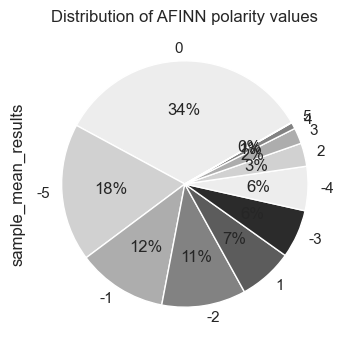

In [30]:
plt.figure(figsize=(4,4))
sns.set(style='white', palette='Greys', font_scale=1.0)

df['sample_mean_results'].value_counts().plot(kind='pie', 
                                          figsize=(4, 4),
                                          autopct='%1.0f%%',
                                          startangle=30, 
                                          title='Distribution of AFINN polarity values')

In [31]:
# change values to sring
df['correct_mean_results'] = df['correct_mean_results'].astype('int32')

# count values of each label type
df['correct_mean_results'].value_counts()

-5    2007
-1     871
-2     862
-3     709
 0     662
-4     626
 1     471
 2     221
 3     141
 4      56
 5       3
Name: correct_mean_results, dtype: int64

<AxesSubplot: title={'center': 'Distribution of AFINN polarity values'}, ylabel='correct_mean_results'>

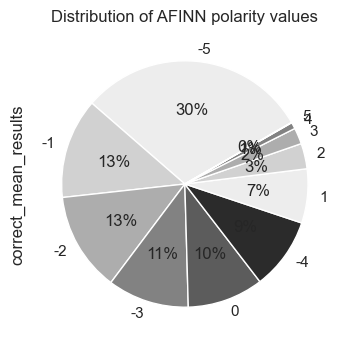

In [32]:
plt.figure(figsize=(4,4))
sns.set(style='white', palette='Greys', font_scale=1.0)

df['correct_mean_results'].value_counts().plot(kind='pie', 
                                          figsize=(4, 4),
                                          autopct='%1.0f%%',
                                          startangle=30, 
                                          title='Distribution of AFINN polarity values')

# Results analysis for 'raw' samples

In [33]:
# create panda dataframe for results
df_results = pd.DataFrame({'sample':df['sample'], 'sentiment':df['polarity'], 'prediction':df['sample_mean_results']})
df_results

,sample,sentiment,prediction
0,- Ajatus siitä että kaikki henkilön tienaamat...,-1,0
1,"- Kaivovertauksessa, viime hallitus on kaivan...",-2,1
2,--´973´¤-.ttu,-5,0
3,-=>Widdu joo<=-,-4,1
4,"- Ei , mutta olen joutunut elämään katsomalla ...",-5,-1
...,...,...,...
6624,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,5,-1
6625,😠👉👩‍💼,-3,1
6626,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,5,0
6627,🤮😡,-4,-1


In [34]:
sentiments = df_results['sentiment'].tolist()
predictions = df_results['prediction'].tolist()

In [35]:
from sklearn.metrics import confusion_matrix, classification_report

class_names = ['-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', '5']

print(classification_report(sentiments, predictions, target_names=class_names, zero_division=0))

              precision    recall  f1-score   support

          -5       0.79      0.29      0.42      3324
          -4       0.08      0.05      0.06       624
          -3       0.11      0.06      0.08       797
          -2       0.08      0.14      0.10       431
          -1       0.06      0.20      0.09       218
           0       0.09      0.35      0.14       565
           1       0.04      0.22      0.07        95
           2       0.09      0.13      0.11       135
           3       0.09      0.09      0.09       137
           4       0.07      0.04      0.05        91
           5       0.67      0.01      0.02       212

    accuracy                           0.21      6629
   macro avg       0.20      0.14      0.11      6629
weighted avg       0.46      0.21      0.25      6629



In [36]:
print(confusion_matrix(sentiments, predictions))

[[ 948  269  243  335  241 1226   50    6    6    0    0]
 [ 106   29   42   78  102  224   38    3    2    0    0]
 [  89   52   48  132  121  282   61    8    4    0    0]
 [  34   11   42   60   79  150   46    7    2    0    0]
 [   8    4   10   38   44   64   38   10    2    0    0]
 [  10    5   28   53  117  198  109   26   16    3    0]
 [   0    1    3    5    9   34   21   11    8    3    0]
 [   1    4    2   10   17   35   22   18   22    4    0]
 [   3    3    2   12   26   12   33   24   13    9    0]
 [   0    4    0    2   13    3   17   33   14    4    1]
 [   1    3    1    7   12   11   37   56   49   33    2]]


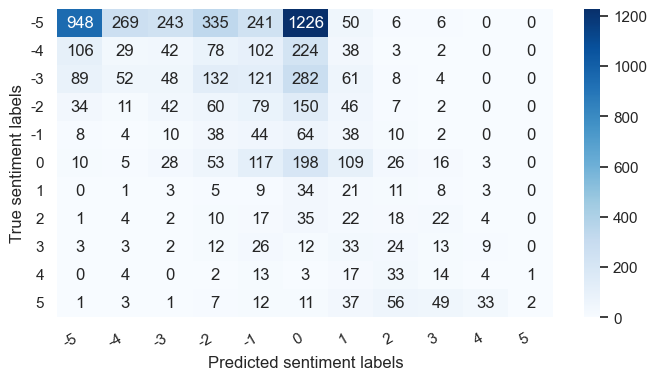

In [37]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment labels')
    plt.xlabel('Predicted sentiment labels');

cm = confusion_matrix(sentiments, predictions)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [38]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# calculate accuracy
total_accuracy = accuracy_score(sentiments, predictions, normalize=True, sample_weight=None)
print('Accuracy  ', total_accuracy)

# calculate f1
total_f1 = f1_score(sentiments, predictions, average='weighted', labels=np.unique(predictions), zero_division=0)
print('F1  ', total_f1)

# calculate precision
total_precision = precision_score(predictions, sentiments, average='weighted', labels=np.unique(predictions), zero_division=0)
print('Precision  ', total_precision)

# calculate recall
total_recall = recall_score(sentiments, predictions, average='weighted', labels=np.unique(predictions), zero_division=0)
print('Recall  ', total_recall)

Accuracy   0.20893045708251623
F1   0.2532123075624084
Precision   0.2378212657864787
Recall   0.20893045708251623


In [39]:
#pip install pycm==4.0
from pycm import ConfusionMatrix
cm = ConfusionMatrix(actual_vector=sentiments, predict_vector=predictions)
cm.print_matrix()

Predict    -5         -4         -3         -2         -1         0          1          2          3          4          5          
Actual
-5         948        269        243        335        241        1226       50         6          6          0          0          

-4         106        29         42         78         102        224        38         3          2          0          0          

-3         89         52         48         132        121        282        61         8          4          0          0          

-2         34         11         42         60         79         150        46         7          2          0          0          

-1         8          4          10         38         44         64         38         10         2          0          0          

0          10         5          28         53         117        198        109        26         16         3          0          

1          0          1          3          5          9

C:\Users\merja\anaconda3\envs\NLPtfgpu\lib\site-packages\pycm\pycm_obj.py:136: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
If confusion matrix has too many zeros (sparse matrix) you can set `sparse` flag to True in printing functions otherwise by using save_csv method to save the confusion matrix in csv format you'll have better demonstration.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


In [40]:
cm.stat(summary=True)

Overall Statistics : 

ACC Macro                                                         0.85617
F1 Macro                                                          0.1124
FPR Macro                                                         0.08038
Kappa                                                             0.07378
NPV Macro                                                         0.91599
Overall ACC                                                       0.20893
PPV Macro                                                         0.19745
SOA1(Landis & Koch)                                               Slight
TPR Macro                                                         0.14419
Zero-one Loss                                                     5244

Class Statistics :

Classes                                                           -5            -4            -3            -2            -1            0             1             2             3             4             5             


C:\Users\merja\anaconda3\envs\NLPtfgpu\lib\site-packages\pycm\pycm_obj.py:204: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
If confusion matrix has too many zeros (sparse matrix) you can set `sparse` flag to True in printing functions otherwise by using save_csv method to save the confusion matrix in csv format you'll have better demonstration.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


# Results analysis for 'correct samples'

In [41]:
# create panda dataframe for results
df_results = pd.DataFrame({'sample':df['sample'], 'sentiment':df['polarity'], 'prediction':df['correct_mean_results']})
df_results

,sample,sentiment,prediction
0,- Ajatus siitä että kaikki henkilön tienaamat...,-1,0
1,"- Kaivovertauksessa, viime hallitus on kaivan...",-2,1
2,--´973´¤-.ttu,-5,-5
3,-=>Widdu joo<=-,-4,-2
4,"- Ei , mutta olen joutunut elämään katsomalla ...",-5,-1
...,...,...,...
6624,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,5,-1
6625,😠👉👩‍💼,-3,1
6626,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,5,0
6627,🤮😡,-4,-1


In [42]:
sentiments = df_results['sentiment'].tolist()
predictions = df_results['prediction'].tolist()

In [43]:
from sklearn.metrics import confusion_matrix, classification_report

class_names = ['-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', '5']

print(classification_report(sentiments, predictions, target_names=class_names, zero_division=0))

              precision    recall  f1-score   support

          -5       0.78      0.47      0.59      3324
          -4       0.07      0.07      0.07       624
          -3       0.11      0.10      0.10       797
          -2       0.08      0.16      0.11       431
          -1       0.07      0.27      0.11       218
           0       0.25      0.29      0.27       565
           1       0.06      0.27      0.09        95
           2       0.10      0.16      0.12       135
           3       0.09      0.09      0.09       137
           4       0.09      0.05      0.07        91
           5       0.33      0.00      0.01       212

    accuracy                           0.31      6629
   macro avg       0.18      0.18      0.15      6629
weighted avg       0.46      0.31      0.36      6629



In [44]:
print(confusion_matrix(sentiments, predictions))

[[1574  463  431  401  260  142   45    4    1    3    0]
 [ 203   43   73   97  110   64   29    4    1    0    0]
 [ 161   70   79  163  146  107   55   12    4    0    0]
 [  44   24   61   70   90   77   55    8    2    0    0]
 [   8    7   16   42   58   38   34   12    2    0    1]
 [  12    7   37   54  122  163  121   30   17    2    0]
 [   0    1    3    7   10   25   26   11   10    2    0]
 [   0    4    4    9   20   28   22   21   24    2    1]
 [   3    2    2   12   28    9   34   25   13    9    0]
 [   0    4    0    2   13    1   16   36   14    5    0]
 [   2    1    3    5   14    8   34   58   53   33    1]]


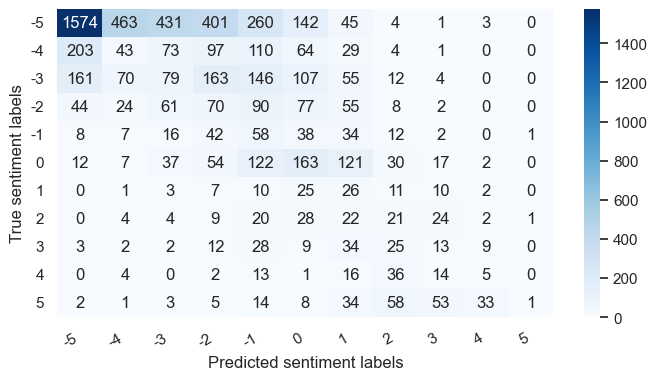

In [45]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment labels')
    plt.xlabel('Predicted sentiment labels');

cm = confusion_matrix(sentiments, predictions)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [46]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# calculate accuracy
total_accuracy = accuracy_score(sentiments, predictions, normalize=True, sample_weight=None)
print('Accuracy  ', total_accuracy)

# calculate f1
total_f1 = f1_score(sentiments, predictions, average='weighted', labels=np.unique(predictions), zero_division=0)
print('F1  ', total_f1)

# calculate precision
total_precision = precision_score(predictions, sentiments, average='weighted', labels=np.unique(predictions), zero_division=0)
print('Precision  ', total_precision)

# calculate recall
total_recall = recall_score(sentiments, predictions, average='weighted', labels=np.unique(predictions), zero_division=0)
print('Recall  ', total_recall)


Accuracy   0.30969980389198976
F1   0.35526167129411457
Precision   0.2724774821380095
Recall   0.30969980389198976


In [47]:
#pip install pycm==4.0
from pycm import ConfusionMatrix
cm = ConfusionMatrix(actual_vector=sentiments, predict_vector=predictions)
cm.print_matrix()

Predict    -5         -4         -3         -2         -1         0          1          2          3          4          5          
Actual
-5         1574       463        431        401        260        142        45         4          1          3          0          

-4         203        43         73         97         110        64         29         4          1          0          0          

-3         161        70         79         163        146        107        55         12         4          0          0          

-2         44         24         61         70         90         77         55         8          2          0          0          

-1         8          7          16         42         58         38         34         12         2          0          1          

0          12         7          37         54         122        163        121        30         17         2          0          

1          0          1          3          7          1

C:\Users\merja\anaconda3\envs\NLPtfgpu\lib\site-packages\pycm\pycm_obj.py:136: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
If confusion matrix has too many zeros (sparse matrix) you can set `sparse` flag to True in printing functions otherwise by using save_csv method to save the confusion matrix in csv format you'll have better demonstration.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


In [48]:
cm.stat(summary=True)

Overall Statistics : 

ACC Macro                                                         0.87449
F1 Macro                                                          0.14776
FPR Macro                                                         0.0727
Kappa                                                             0.14022
NPV Macro                                                         0.92296
Overall ACC                                                       0.3097
PPV Macro                                                         0.18395
SOA1(Landis & Koch)                                               Slight
TPR Macro                                                         0.17657
Zero-one Loss                                                     4576

Class Statistics :

Classes                                                           -5            -4            -3            -2            -1            0             1             2             3             4             5             
A

C:\Users\merja\anaconda3\envs\NLPtfgpu\lib\site-packages\pycm\pycm_obj.py:204: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
If confusion matrix has too many zeros (sparse matrix) you can set `sparse` flag to True in printing functions otherwise by using save_csv method to save the confusion matrix in csv format you'll have better demonstration.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


# Conclusions

### Accuracy, F1, Precision, and Recall

 - 'raw' text samples

Accuracy   0.21
F1   0.25
Precision   0.24
Recall   0.21

 - 'corrected' text samples

Accuracy   0.31
F1   0.36
Precision   0.27
Recall   0.31

The Finnish afinn method had significant challenges to carry multilabel classification for Finnish text samples.

The original 'raw' samples included significant amount of incorrectly written text.

Accuracy value (as value to define how well the set of predicted labels match the corresponding set of true labels) was higher on 'corrected' text samples (accuracy 0.31) than with original 'raw' samples (accuracy 0.21).

F1 value (as value which define how well the predicted positive labels match the corresponding positive true labels) was higher on 'corrected' text samples (accuracy 0.36) than with original 'raw' samples (accuracy 0.25).

Precision (as value to define how well the classifier does not label a negative sample to a positive one) was low for both 'raw' (precision 0.24) and 'corrected' (precision 0.27) sample datasets.

Recall (as value to define how well the classifier does find all the positive samples) was quite low on 'raw' samples (recall 0.21) and on 'corrected' samples (recall 0.31).

### Confusion matrix analysis

Comparison of confusion matrix results reveals that sentiment lexicon based multilabel classification with afinn scoring method produces better results on text data samples that include correctly (or almost correctly) written Finnish.

The amount of incorrectly predicted (labeled) neutral (0) samples is significantly higher on 'raw' samples dataset that it is on 'corrected' samples dataset.

### Conclusion

Lexicon based multilabel classification provides low results in general. 

When text samples are written in correct Finnish, and text samples include words, emoticons or emojis that are included in sentiment lexicons, also the multilabel classification can achieve better results.
